In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import yfinance as yf
from tinvest import SyncClient
import websocket
from scipy import stats
import datetime as dt
from pandas_datareader import data as wb

In [2]:
token = 'YOUR_TOKEN'

In [3]:
def toFixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

In [4]:
def api_connect(token):
    client = SyncClient(token, use_sandbox=False)
    return client

In [5]:
async def main():
    client = AsyncClient(token, use_sandbox=False)
    await client.get_accounts()

In [6]:
def usd_cur(client):
    response = client.get_market_orderbook(figi='BBG0013HGFT4', depth=1)  # tinvest.PortfolioResponse
    return response.payload.last_price

In [7]:
def get_id(client):
    response = client.get_accounts()
    broker_id = iis_id = 0
    for acc in response.payload.accounts:
        if acc.broker_account_type.value == 'Tinkoff':
            broker_id = acc.broker_account_id
        if acc.broker_account_type == 'TinkoffIis':
            iis_id = acc.broker_account_id
    return broker_id, iis_id

In [8]:
def get_portfolio(client,id, usd):
    response = client.get_portfolio(broker_account_id=id)
    df = pd.DataFrame()
    for pos in response.payload.positions:
        cur = 1
        if pos.average_position_price.currency == 'RUB':
            cur = usd
        name = pos.name
        n_shares = pos.balance
        ticker = pos.ticker
        isin = pos.isin
        figi = pos.figi
        currency = pos.average_position_price.currency.value
        price = float(toFixed((pos.average_position_price.value + pos.expected_yield.value/pos.balance)/cur, 1))
        position = float(toFixed((pos.average_position_price.value * pos.balance + pos.expected_yield.value)/cur, 1))
        average_price = float(toFixed(pos.average_position_price.value/cur, 1))
        result = float(toFixed(pos.expected_yield.value/cur,1))
        df = df.append(pd.Series([ticker, figi, isin, currency, price, position,n_shares, average_price, result]),ignore_index=True)
    df.columns = ['ticker', 'figi', 'isin', 'currency', 'price', 'position', 'n_shares','average', 'result']
    df['share'] = [float(toFixed(pos*100/sum(df['position']),1)) for pos in df['position']]
    df = df.sort_values(by=['share'], ascending=False)
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    return df

In [9]:
def get_operations(client,start, end, id, usd):
    operations = pd.DataFrame()
    response = client.get_operations(from_=start.isoformat(), to=end.isoformat(), broker_account_id=id)
    for pos in response.payload.operations:
        cur = 1
        if pos.currency == 'RUB':
            cur = usd
        if pos.operation_type.value in ('Buy', 'Sell'):
            quantity = pos.quantity
            quantity_ex = pos.quantity_executed
            price = pos.price
        else:
            quantity = 0
            price = 0
            quantity_ex = 0
        operations = operations.append(pd.Series([pos.date.date(),pos.figi, pos.operation_type.value, float(quantity_ex),float(quantity), float(price/cur), float(pos.payment/cur)]),ignore_index=True)
    operations.columns = ['date', 'figi', 'type', 'quantity_ex', 'quantity', 'price', 'result']
    return operations

In [10]:
def get_market_search(client,oper):
    stocks = pd.DataFrame()
    for fig in oper.index:
        response = client.get_market_search_by_figi(fig)
        stocks = stocks.append(pd.Series([response.payload.name, response.payload.ticker, fig]),ignore_index=True)
    stocks.columns = ['name', 'ticker','figi']
    return stocks

In [11]:
def get_stock_data(tickers,delim=1000000):
    stockdata = pd.DataFrame()
    t = yf.Ticker('USDCNY=X')
    cny = float(t.info['previousClose'])
    t = yf.Ticker('USDC-RUB')
    rub = float(t.info['previousClose'])
    for tick in tickers:
        t = yf.Ticker(tick)
        val = 1
        try:
            if t.info['country'] == 'China':
                val = cny
            if t.info['country'] == 'Netherlands':
                val = rub
            if len(t.earnings.values) == 0:
                revenue = 0
                earnings = 0
            else:
                rev = t.earnings['Revenue']
                earn = t.earnings['Earnings']
                earnings = float(toFixed(earn.values[len(earn)-1]/(delim*val),1))
                revenue = float(toFixed(rev.values[len(rev)-1]/(delim*val),1))
            if t.info['forwardPE'] is None:
                fpe = t.info['forwardPE']
            else:
                fpe = float(toFixed(t.info['forwardPE'],1))
            if t.info['beta'] is None:
                beta = t.info['beta']
            else:
                beta = float(toFixed(t.info['beta'],1))
            if t.info['shortPercentOfFloat'] is None:
                short = t.info['shortPercentOfFloat']
            else:
                short = float(toFixed(t.info['shortPercentOfFloat']*100,1))
            if revenue == 0.:
                ps = float('inf')
            else:
                ps = float(toFixed(t.info['marketCap'] / (revenue*delim),1))
            day200 = float(toFixed(t.info['twoHundredDayAverage'],1))
            day50 = float(toFixed(t.info['fiftyDayAverage'],1))
            avg10dayvolume = float(toFixed(t.info['averageDailyVolume10Day']/delim,1))
            stockdata = stockdata.append(pd.Series([tick,revenue,earnings, fpe, ps, beta, short,day200,day50,avg10dayvolume]),ignore_index=True)
        except (IndexError, ImportError, KeyError) as e:
            continue
    stockdata.columns = ['ticker', 'revenue', 'earnings', 'forward PE', 'PS', 'beta', 'short percent','avg200','avg50','avgvolume10']
    return stockdata

In [12]:
def get_categories(stockdata):
    categories = list()
    for s in stockdata.iloc:
        if ((s.revenue > 10000) and (s.earnings > 1000)):
            categories.append('A')
        elif ((s.revenue > 2000) and(s.earnings > 100)):
            categories.append('B')
        elif (s.revenue > abs(s.earnings)):
            categories.append('C')
        else:
            categories.append('D')
    return categories

In [13]:
def data_for_compare(ticks):
    data = pd.DataFrame()
    for ticker in ticks.index:
        data[ticker]=wb.DataReader(ticker,data_source='yahoo',start='1900-01-01')['Adj Close']
        data[ticker] *= int(ticks.loc[ticker].values)
        data[ticker] = data[ticker].fillna(data[ticker].dropna()[0])
# data = data.drop(['MAIL'],axis=1)
# data = data.fillna(0)
    data['portfolio'] = data.sum(axis=1)
    data = data['portfolio']
    return data

In [14]:
def compare(change, start):
    result = list()
    result.append(start)
    for i in range(1, len(change)):
         result.append(result[i-1]*(1+change[i]))
    return pd.Series(result)

In [15]:
client = api_connect(token)

In [16]:
broker, iis = get_id(client)

In [17]:
usd = usd_cur(client)

In [18]:
df = get_portfolio(client,iis, usd)

Текущее состояние портфеля

In [19]:
df

,ticker,figi,isin,currency,price,position,n_shares,average,result,share
0,BIDU,BBG000QXWHD1,US0567521085,USD,193.0,1157.8,6,259.9,-401.9,17.3
1,COIN,BBG00ZGF7771,US19260Q1076,USD,229.0,1144.9,5,307.1,-390.6,17.1
2,SQ,BBG0018SLC07,US8522341036,USD,213.8,855.2,4,233.1,-77.0,12.8
3,BABA,BBG006G2JVL2,US01609W1027,USD,219.1,657.4,3,222.9,-11.3,9.8
4,TDOC,BBG0019T5SG0,US87918A1051,USD,146.3,585.2,4,190.7,-177.5,8.8
5,AYX,BBG000BGZT72,US02156B1035,USD,76.6,536.2,7,91.1,-101.4,8.0
6,JD,BBG005YHY0Q7,US47215P1066,USD,75.5,377.6,5,77.0,-7.2,5.7
7,FSLY,BBG004NLQHL0,US31188V1008,USD,47.5,332.5,7,60.0,-87.7,5.0
8,PLTR,BBG000N7QR55,US69608A1088,USD,24.1,240.6,10.0,24.7,-6.8,3.6
9,USD000UTSTOM,BBG0013HGFT4,None,RUB,1.0,231.9,231.86,1.0,-1.9,3.5


Догрузим эмитенты, которыми мы владели в прошлом

In [20]:
start = datetime(2020, 1, 1, 0, 0, 0, tzinfo=timezone('Europe/Moscow'))
end = datetime.now(tz=timezone('Europe/Moscow'))
operations = get_operations(client,start, end, iis, usd)

In [21]:
oper = operations.groupby(['figi']).sum()

In [22]:
oper

,quantity_ex,quantity,price,result
figi,,,,
BBG000000000,1000.0,1200.0,0.524441,0.73
BBG000B9XRY4,4.0,4.0,391.430000,-13.71
BBG000BBXB74,2.0,2.0,140.600000,-0.13
BBG000BCJ161,1.0,1.0,91.870000,-92.15
BBG000BGZT72,17.0,19.0,1890.690000,-731.25
...,...,...,...,...
BBG111111111,8982.0,10509.0,2.346453,16.53
BBG222222222,400.0,400.0,0.157700,0.50
TCS00A102EK1,6000.0,6000.0,0.601700,4.40


In [23]:
stocks = get_market_search(client, oper)

In [24]:
stocks = stocks.set_index('figi').join(oper)

In [25]:
tickers = stocks['ticker'].values

In [27]:
stockdata = get_stock_data(tickers)

Также мы выгрузили различные полезные показатели.
По неизвестной причине перестаои подтягиваться данные по прибыли и выручке.
Раньше все работало.

In [28]:
stockdata

,ticker,revenue,earnings,forward PE,PS,beta,short percent,avg200,avg50,avgvolume10
0,AAPL,0.0,0.0,23.5,inf,1.2,0.6,127.7,128.5,74.0
1,SRPT,0.0,0.0,-18.7,inf,1.5,11.3,100.6,74.1,1.5
2,AYX,0.0,0.0,178.3,inf,0.7,6.9,100.9,79.2,0.8
3,ZYXI,0.0,0.0,19.9,inf,0.8,20.4,15.5,14.9,0.2
4,FISV,0.0,0.0,17.6,inf,0.9,2.2,116.1,117.8,4.2
5,IBM,0.0,0.0,12.2,inf,1.2,2.8,130.2,143.7,3.4
6,NOK,0.0,0.0,17.7,inf,0.6,None,4.3,4.8,67.5
7,MRK,0.0,0.0,11.1,inf,0.4,0.8,74.5,74.0,14.7
8,EXEL,0.0,0.0,23.5,inf,1.0,3.5,22.4,24.1,1.5
9,INTC,0.0,0.0,12.5,inf,0.6,1.5,57.1,57.4,22.5


Здесь я делю акции по категориям.
А: надежные компании с высокой прибылью с капитализацией более 10 млрд
В: прибыльные компании средней капитализации
С: убыточные компании с положительной выручкой
D: убыточные компании с околонулевой выручкой, стартапы на раннем этапе

Разделение по категориям в данный момент не работает по той же причине :(    

In [29]:
categories = pd.Series(get_categories(stockdata))

In [30]:
stockdata = pd.concat([stockdata,categories], axis=1)

In [31]:
stockdata.columns = ['ticker', 'revenue', 'earnings', 'forward PE', 'PS', 'beta', 'short percent','avg200','avg50','avgvolume10','category']

In [32]:
portfolio = df.join(stockdata.set_index('ticker'), on='ticker', how='right')

In [33]:
for cat in ['A','B','C','D']:
    s = sum(portfolio[portfolio['category'] == cat]['share'].dropna())
    print(cat, s)

A 0
B 0
C 0
D 78.7


In [34]:
s = stocks.set_index('ticker').join(portfolio.set_index('ticker'), lsuffix='_oper', rsuffix='_port', on='ticker', how='right')

In [35]:
s['position'] = s['position'].fillna(0)

In [36]:
s['result'] = s['result_oper'] + s['position']

In [37]:
s = s.drop(['isin','result_port','result_oper', 'figi', 'currency','price_oper','quantity_ex','quantity'],axis=1)

In [38]:
s['share'] = s['share'].fillna(0)
s['average'] = s['average'].fillna(0)
s['n_shares'] = s['n_shares'].fillna(0)

In [39]:
for tick in s[s['price_port'].isna()].index:
    t = yf.Ticker(tick)
#     s.loc[tick] = {'price': t.info['open']}
    s.loc[tick] = s.loc[tick].fillna(t.info['open'])

Итоговый результат

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(s.sort_values(by=['result'], ascending=False))

,name,price_port,position,n_shares,average,share,revenue,earnings,forward PE,PS,beta,short percent,avg200,avg50,avgvolume10,category,result
ticker,,,,,,,,,,,,,,,,,
SQ,Square,213.8000,855.2,4,233.1,12.8,0.0,0.0,101.3,inf,2.4,8.4,229.1,225.5,7.6,D,169.160000
TCS,TCS Group (Tinkoff Bank holder),13.1000,0.0,0,0.0,0.0,0.0,0.0,13.3,inf,1.3,20.7,13.6,13.7,0.7,D,115.816805
INTC,Intel Corporation,56.5500,0.0,0,0.0,0.0,0.0,0.0,12.5,inf,0.6,1.5,57.1,57.4,22.5,D,89.500000
CLDR,Cloudera Inc,15.8500,0.0,0,0.0,0.0,0.0,0.0,31.7,inf,1.1,7.8,13.7,12.8,19.9,D,69.740000
GTHX,G1 Therapeutics Inc,21.2000,0.0,0,0.0,0.0,0.0,0.0,-6.1,inf,2.2,15.4,21.7,21.4,1.2,D,64.070000
PD,Pagerduty Inc,38.6400,0.0,0,0.0,0.0,0.0,0.0,-196.4,inf,1.3,16.3,42.4,39.0,2.0,D,61.480000
PSTG,Pure Storage Inc,18.5600,0.0,0,0.0,0.0,0.0,0.0,35.9,inf,1.4,6.5,21.9,19.1,5.1,D,47.530000
ALXN,Alexion Pharmaceuticals,176.4600,0.0,0,0.0,0.0,0.0,0.0,12.5,inf,1.3,4.2,155.0,172.1,2.0,D,44.690000
BIIB,Biogen,274.1700,0.0,0,0.0,0.0,0.0,0.0,14.2,inf,0.4,2.3,265.1,273.2,1.6,D,39.980000


In [41]:
df = df[((df['ticker'] != 'USD000UTSTOM') & (df['ticker'] != 'EUR_RUB__TOM'))]

In [42]:
ticks = df[['ticker', 'n_shares']]
ticks = ticks.set_index('ticker')

Здесь я пытаюсь сравнить свой портфель с индексом.
Формирования результата своего портфеля немного специфичное.
Т.к. некоторые компании в моем портфеле недавно вышли на биржу, а рассматривать хочется период хотя бы полтора года, я заменил null на стоимость акции в первый день торгов.
Позже придумаю, как сделать все умнее.

In [43]:
data = data_for_compare(ticks)

In [44]:
t = yf.Ticker('SPY')
spy = t.history(period='max')
spy_roll = spy['Close'].rolling(200).mean().dropna()
spy_roll_50 = spy['Close'].rolling(50).mean().dropna()
spy_curve = spy.join(spy_roll, rsuffix='_roll200')[['Close','Close_roll200']]
spy_curve = spy_curve.join(spy_roll_50, rsuffix='_roll50')[['Close','Close_roll200','Close_roll50']]

In [45]:
spy_norm = spy_curve['Close'] / spy_curve['Close'].max()
data_norm = data/data.max()
spy_close = pd.DataFrame(spy_curve['Close'])
comp = spy_close.join(data).dropna()
comp['Close_per'] = comp['Close'].pct_change()

In [46]:
comp = comp[3650:]

In [47]:
cmp = compare(comp['Close_per'].values, comp['portfolio'][0])

In [48]:
comp = comp.join(pd.DataFrame(cmp).set_index(comp.index))

In [49]:
comp = comp.drop(['Close', 'Close_per'],axis=1)
comp.columns = ['portfolio','sp500']

<AxesSubplot:xlabel='Date'>

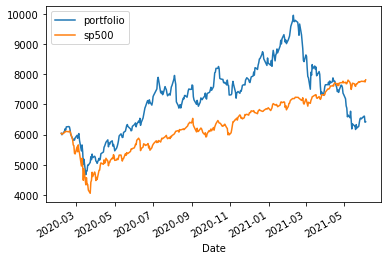

In [50]:
comp.plot()

Не оч удачно :(